In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
import blackjax
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from jax.nn import sigmoid

rng_key = jax.random.PRNGKey(0) 

/Users/madhav/anaconda3/envs/experiment-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d = 10  # Specify the desired length
true_centeredness = jax.random.uniform(rng_key, shape=(d,))
print(true_centeredness)

[0.35490513 0.60419905 0.4275843  0.23061597 0.32985854 0.43953657
 0.25099766 0.27730572 0.7678207  0.71474564]


In [3]:
def funnel(true_centeredness = true_centeredness):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Normal(0,1))
    numpyro.sample('x', dist.Normal(mu*(1-true_centeredness), jnp.exp(tau*(1-true_centeredness))))

In [4]:
num_warmup = 1000

adapt = blackjax.window_adaptation(blackjax.nuts, funnel)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

centeredness [0.2331313  0.8110792  0.5266793  0.26382676 0.5727146  0.38180152
 0.27624917 0.41962746 0.8309408  0.7102326 ]
[0.2331313  0.8110792  0.5266793  0.26382676 0.5727146  0.38180152
 0.27624917 0.41962746 0.8309408  0.7102326 ]
centeredness [0.00801468 0.70278984 0.18704832 0.00102213 0.27868122 0.21205175
 0.14369886 0.14318104 0.6822318  0.5602168 ]
[0.00801468 0.70278984 0.18704832 0.00102213 0.27868122 0.21205175
 0.14369886 0.14318104 0.6822318  0.5602168 ]
centeredness [1.1655068e-04 4.3758669e-01 2.6419836e-01 4.8612521e-04 3.8834220e-05
 4.7974658e-04 1.3802358e-04 7.8203826e-05 3.0399859e-01 4.1182762e-01]
[1.1655068e-04 4.3758669e-01 2.6419836e-01 4.8612521e-04 3.8834220e-05
 4.7974658e-04 1.3802358e-04 7.8203826e-05 3.0399859e-01 4.1182762e-01]
centeredness [0.00189516 0.28886133 0.0776089  0.05808126 0.01754247 0.0064375
 0.00096763 0.0010709  0.22195525 0.32548556]
[0.00189516 0.28886133 0.0776089  0.05808126 0.01754247 0.0064375
 0.00096763 0.0010709  0.2219552

In [5]:
# centeredness [0.2331313  0.8110792  0.5266793  0.26382676 0.5727146  0.38180152
#  0.27624917 0.41962746 0.8309408  0.7102326 ]
# 50
# centeredness [0.00765032 0.7029564  0.18712614 0.00096778 0.27875057 0.21167767
#  0.14377424 0.14323206 0.6824051  0.5601767 ]
# 100
# centeredness [2.5076304e-05 4.3519798e-01 1.2396595e-01 8.4231142e-05 6.2584415e-02
#  1.2584248e-01 4.2179160e-02 3.0225559e-04 4.8173702e-01 4.0736115e-01]
# 200
# centeredness [0.00096234 0.23994967 0.08856567 0.00061748 0.01383669 0.06310479
#  0.05614521 0.00103874 0.34150314 0.2921067 ]
# 500
# centeredness [2.0366977e-04 1.4507121e-01 9.4087429e-02 3.7881808e-04 3.9702136e-04
#  5.0606292e-02 1.0031267e-03 2.4753883e-02 2.8041726e-01 2.3236729e-01]

In [6]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [7]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [8]:
def scatterplt(samples):
    fig, axes = plt.subplots(5, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['x_decentered'].T
    for i in range(10):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'x_{i}')
        axes[i].set_ylabel('log_std')

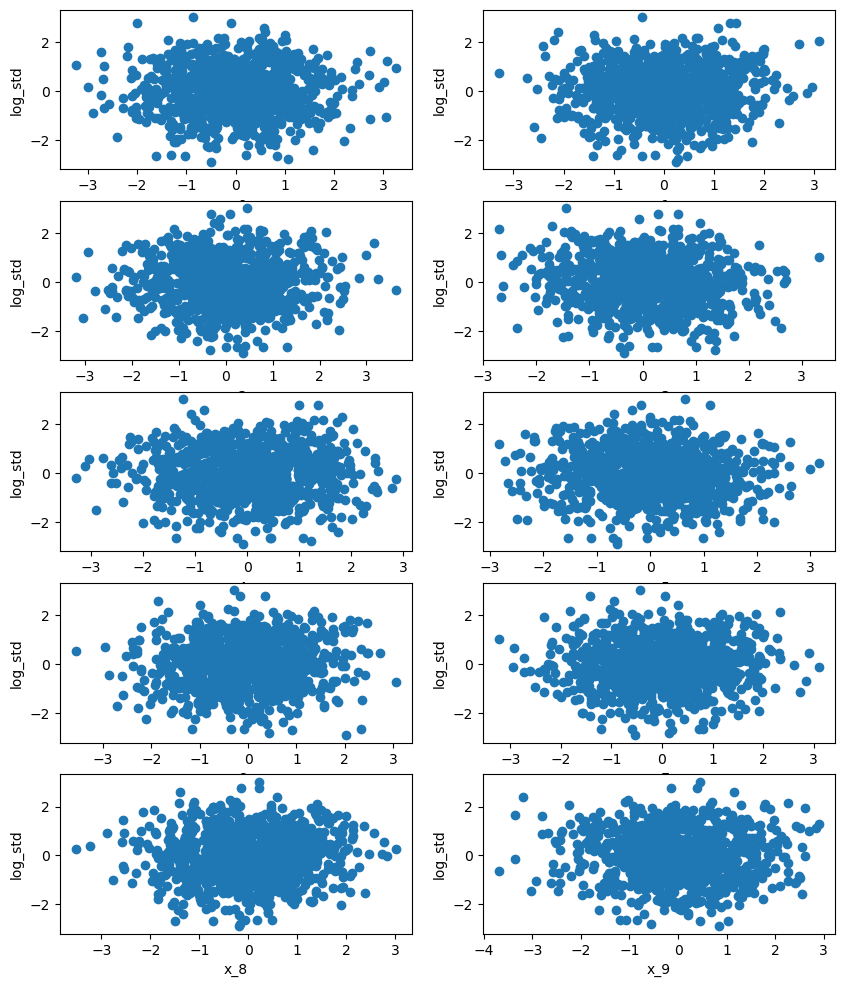

In [9]:
scatterplt(states[0])